# パターン認識問題を解いてみる

### パターン識別編（畳み込み演算の導入）

それでは手書き文字データセット MNIST の識別を行ってみましょう.
外部と通信してデータをとってきます．

解説付きでコードを示しています．使い方としては

1. 上から順に読んで（重要），
2. セルを実行していってください．
3. 理解できない場合は，スタッフに質問を投げるなどしてください．
4. 理解が進んだら，自分のノートを作成し，ページにコードを真似して記述していってください．

In [1]:
import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist, fashion_mnist

MNIST のデータセットの読み込みを `tensorflow.keras.datasets.mnist.load_data()` で行うと，学習用の文字データとラベル，テスト用の文字データとラベルが帰ってくる

In [2]:
# データセットの読み込み
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 数値データは 28 x 28 の画素からなり， 画素値は[0, 255] の数値．　画素値が大きいと取り扱いにくいので，全部 [0, 1] へ標準化

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255 #画像輝度値は [0, 255] で定義されるので，[0, 1] になるようにスケーリング
x_test /= 255  #同上

4431872/4422102 [==============================] - 0s 0us/step


データの次元が 28 x 28 で，多次元なので，3層の多層パーセプトロンを試してみる．
本質はロジスティック回帰と一緒で，関数系が複雑になったのが違う程度です．

最適化プロセスの本質部分である

### モデル $f(x_n; w)$ とラベルとのロスが小さくなるように $w$ を求める．

という部分は変わりません．

## Keras + TensorFlow を用いた解法

結構計算時間かかります．

In [3]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation  #畳み込み関連を追加
from tensorflow.keras.utils import to_categorical

In [4]:
# ラベルデータを tensorflow の形式に合致するよう変換 

# データは， 28x 28 =784 次元で，２次元配列の形をしている意味は今はないので，
# reshape で１次元になおしてしまおう

input_shape = 28 * 28
x_train = x_train.reshape(60000, input_shape)
x_test = x_test.reshape(10000, input_shape)

# 他クラス分類ように y をカテゴリカルな one-hot-vector に変換．
# 10個の変数の所定位置にフラグを立てて変数値を表すやりかた．
# ラベルデータがちょっと扱いにくいので 10 要素のベクトルで表す (one-hot vector 表現)
# この表現は，
# ラベルが '0' であれば [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# ラベルが '1' であれば [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
# ラベルが '2' であれば [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
# といった表現になる

num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# print(y_train[0].shape) # 形状を確認するのは重要

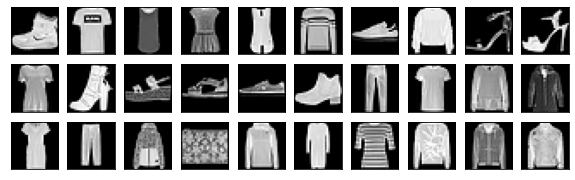

In [5]:
# データ表示
fig = plt.figure(figsize=(10, 3))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i].reshape((28, 28)), cmap='gray')

In [6]:
# モデルの構築は今までと一緒

num_z1 = 20 # 中間層の個数．個数は適当
num_z2 = 20 # 中間層の個数．個数は適当
ker_size = 3 # 畳み込み核の大きさ

model = Sequential()   # 階層型のモデルを選択
model.add(Conv2D(num_z1, ker_size, padding='same', activation='relu', input_shape=(28, 28, 1)))
#model.add(Dropout(0.5))  # mini batch毎にランダムで半分の結合をドロップアウトさせます．過学習対策の一種です
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(num_z2, ker_size, padding='same', activation='relu'))
#model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Keras の場合，conv から dense に移行する時には，テンソルをベクトルに変換する操作(Flatten)が必要です．
model.add(Dense(10, activation='softmax'))

model.summary() # モデルの確認（重要！）

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 20)        200       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 20)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 20)        3620      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 20)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 980)               0         
                                                                 
 dense (Dense)               (None, 10)                9

In [7]:
#最適化手法を指定
model.compile(loss='categorical_crossentropy',  optimizer='adam') 

In [8]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)
# 学習によるパラメータフィット(時間かかります)
hist = model.fit(x_train, y_train, epochs=20, batch_size=1000, verbose=0)

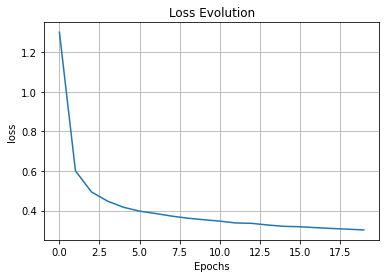

In [9]:
# ロスの値が学習によってどう変わるかを表示

plt.plot(hist.history['loss'])
#plt.semilogy(hist.history['loss'])
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.grid()

かなり頑張って収束しているぽい．
とりあえず，いくつかのテストサンプルで予測してみる

予測は，1-hot vector 表現として出てくる
クラス番号をしりたい

True label 9
Estimate label 9


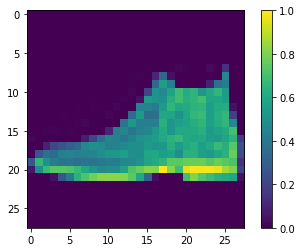

In [10]:
p = 0   # パターン番号（ここを適当に変えると別のパターンをテストできる

# print('真値の 1-hot-vector 表現', y_test[p])
print('True label', np.argmax(y_test[p]))
print('Estimate label', np.argmax(model.predict(x_test[p:p+1])))

plt.imshow(x_test[p].reshape(28, 28))
plt.colorbar()

じゃ，統計を採ってみよう

In [11]:
#y_predict = model.predict_classes(x_test)  #predict_classes が deprecated なので変更
y_predict = np.argmax(model.predict(x_test), axis=-1)

# テストのラベルは 1-hot-vector になっているので 差分をとる
residual = to_categorical(y_predict) - y_test

# 各行を見てって，すべてが０であれば，正しく予測できているが，
# そうでない場合は間違っている．
# とりあえず，間違いの個数をピックアップ

errnum = residual.max(axis=1).sum()

# １0000 個中の間違い個数の割合がご識別率
print( "Error rate = %.3f" % (errnum / 10000))

Error rate = 0.117


誤差率をかなり減らせる（最適化次第だけど）．
適当に作ってる割には，まずますの成績